In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from sklearn.neighbors import NearestNeighbors

from data import stratified_kfold
from utils import seed_everything

In [2]:
class Config:
    checkpoint = '/root/dl_whale_classification/pths_individual'
    test = False
    tta = False
    resume_epoch = 0
    iters_to_accumulate = 1
    resume_root = None
    wandb_log = True
    model_name = 'tf_efficientnet_b6_ns'
    fold = 0
    n_split = 5
    seed = 2022
    data_dir = '/root/data2/' # root/data/train_images
    root_dir = '.'
    batch_size = 8
    lr = 1e-4
    weight_decay = 0.0005
    epoch = 20
    exp_name = 'test'
config = Config()

In [3]:
seed_everything(2022)

In [4]:
df = pd.read_csv('/root/data/train.csv')
df = df.iloc[:len(df)]
df.species.replace({"globis": "short_finned_pilot_whale",
                  "pilot_whale": "short_finned_pilot_whale",
                  "kiler_whale": "killer_whale",
                  "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [5]:
specie_unique = df.species.unique()
specie_indices = range(len(specie_unique))
species2idx = {k: v for k, v in zip(specie_unique, specie_indices)}
df.species = df.species.map(species2idx)

individual_unique = df.individual_id.unique()
individual_indices = range(len(individual_unique))
individual2idx = {k : v for k, v in zip(individual_unique, individual_indices)}
df.individual_id = df.individual_id.map(individual2idx)

In [6]:
df_single = df[df['individual_id'].map(df['individual_id'].value_counts()) == 1]
df_others = df[df['individual_id'].map(df['individual_id'].value_counts()) > 1]

In [220]:
fold = 0

In [221]:
train_single, valid_single = stratified_kfold(df=df_single, fold=fold, n_split=config.n_split, seed=config.seed, target_col='species')
train_others, valid_others = stratified_kfold(df=df_others, fold=fold, n_split=config.n_split, seed=config.seed, target_col='individual_id')

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [222]:
train_single_indices = np.take(df_single.index.to_numpy(), train_single) # 실제 index    
train_others_indices = np.take(df_others.index.to_numpy(), train_others)
valid_single_indices = np.take(df_single.index.to_numpy(), valid_single)
valid_others_indices = np.take(df_others.index.to_numpy(), valid_others)

In [223]:
full_train_indices = np.sort(np.concatenate((train_single_indices, train_others_indices), axis=0))
full_valid_indices = np.sort(np.concatenate((valid_single_indices, valid_others_indices), axis=0))

In [224]:
embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))

In [225]:
embed_train = torch.load(embeds_train[fold]).numpy()

In [226]:
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')

In [227]:
neigh.fit(embed_train[full_train_indices])

NearestNeighbors(metric='cosine', n_neighbors=1)

# top3 체크 + 폴드별 thr 측정

In [228]:
distance1, indices1 = neigh.kneighbors(embed_train[valid_single_indices], n_neighbors=3, return_distance=True) # 80 %에 해당하는 index
distance2, indices2 = neigh.kneighbors(embed_train[valid_others_indices], n_neighbors=3, return_distance=True)

In [229]:
indices1

array([[22910, 35936, 35343],
       [ 1033,   483, 15866],
       [15994, 37428, 36043],
       ...,
       [ 9713, 23743,  3332],
       [37664, 11587, 37451],
       [25353, 33380, 10885]])

161

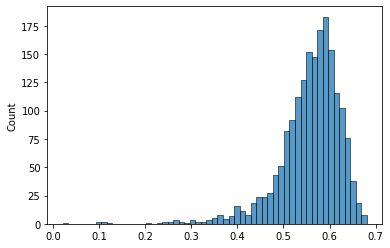

In [230]:
# single
neigh_trues = df.individual_id[valid_single_indices].values
sns.histplot(distance1[:,0])
(distance1[:,0] < 0.469).sum()

In [231]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices2[:,0].reshape(-1)] # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct1 = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong1 = (neigh_preds != neigh_trues)
print('min, mean, max (total):', distance2.min(), distance2.mean(), distance2.max())
print('min, mean, max (correct):', distance2[correct1].min(), distance2[correct1].mean(), distance2[correct1].max())
print('min, mean, max (wrong):', distance2[wrong1].min(), distance2[wrong1].mean(), distance2[wrong1].max())
print('correct %', len(distance2[correct1])/len(distance2), len(distance2[correct1]))
print('wrong %', len(distance2[wrong1])/len(distance2), len(distance2[wrong1]))

min, mean, max (total): 0.0007121563 0.26697522 0.70874476
min, mean, max (correct): 0.0007121563 0.19411598 0.70874476
min, mean, max (wrong): 0.004982829 0.52423465 0.70154834
correct % 0.7792938360263315 6511
wrong % 0.22070616397366846 1844


In [232]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices2[:,1].reshape(-1)] # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct2 = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong2 = (neigh_preds != neigh_trues)
print('min, mean, max (total):', distance2.min(), distance2.mean(), distance2.max())
print('min, mean, max (correct):', distance2[correct2].min(), distance2[correct2].mean(), distance2[correct2].max())
print('min, mean, max (wrong):', distance2[wrong2].min(), distance2[wrong2].mean(), distance2[wrong2].max())
print('correct %', len(distance2[correct2])/len(distance2))
print('wrong %', len(distance2[wrong2])/len(distance2))

min, mean, max (total): 0.0007121563 0.26697522 0.70874476
min, mean, max (correct): 0.0007121563 0.1619706 0.680019
min, mean, max (wrong): 0.0056905746 0.52226365 0.70874476
correct % 0.708557749850389
wrong % 0.291442250149611


In [233]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices2[:,2].reshape(-1)] # k neighbor 예측값
neigh_trues = df.individual_id[valid_others_indices].values
correct3 = (neigh_preds == neigh_trues) # neigh 예측값중 맞은 index
wrong3 = (neigh_preds != neigh_trues)
print('min, mean, max (total):', distance2.min(), distance2.mean(), distance2.max())
print('min, mean, max (correct):', distance2[correct3].min(), distance2[correct3].mean(), distance2[correct3].max())
print('min, mean, max (wrong):', distance2[wrong3].min(), distance2[wrong3].mean(), distance2[wrong3].max())
print('correct %', len(distance2[correct3])/len(distance2))
print('wrong %', len(distance2[wrong3])/len(distance2))

min, mean, max (total): 0.0007121563 0.26697522 0.70874476
min, mean, max (correct): 0.0007121563 0.14802217 0.6800877
min, mean, max (wrong): 0.0056905746 0.51421696 0.70874476
correct % 0.6751645721125075
wrong % 0.32483542788749253


In [234]:
(wrong1 & correct2).sum() # top 2에 new 박는게 여기까진 최고 - 종분류 한다면?

164

In [235]:
((wrong1 & wrong2) & correct3).sum()

84

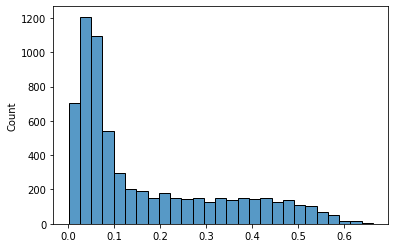

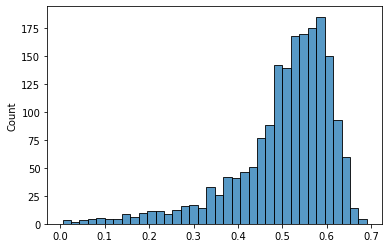

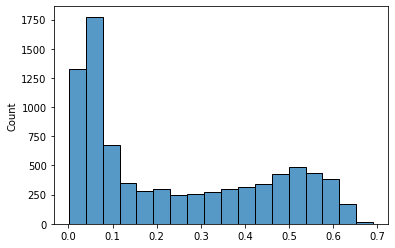

In [236]:
sns.histplot(distance2[:,0][correct1])
plt.show()
sns.histplot(distance2[:,0][wrong1])
plt.show()
sns.histplot(distance2[:,0])
plt.show()

In [237]:
value = 1e9
best = 0
best_x = 0
best_y = 0

value_ = 1e9 # 양방향 최소 차이
best_ = 0
best_x_ = 0
best_y_ = 0
for i in np.arange(0.40, 0.55, 0.001):
    thr = i # 0.455
    x,y,z = (distance2[:,0][correct1] > thr).sum(), (distance2[:,0][wrong1] < thr).sum(), (distance1[:,0] < thr).sum()
    if value > x+y+z:
        value = (x+y+z)
        best_x = x
        best_y = y
        best = thr
    if value_ > x+y:
        value_ = x+y
        best_x_ = x
        best_y_ = y
        best_ = thr
best, value, (best_x, best_y), best_, (best_x_ + best_y_), (best_x_, best_y_), value_

(0.44300000000000006,
 1107,
 (622, 379),
 0.4820000000000001,
 957,
 (409, 548),
 957)

### 1번 : 전체 데이터에 대한 test추론 후 distance (id or image) 평균값으로 앙상블

In [238]:
len(full_valid_indices)

10207

기본 threshold
fold0 thr : "only others" 0.482 957, (409, 548) top2,3 164, 84 "total" 0.443 1107, (622, 379)
fold1 thr : "only others" 0.473 983, (490, 493) top2,3 145, 91 "total" 0.453 1101, (582, 391)
fold2 thr : "only others" 0.476 top2,3 127, 89 (488, 487)      "total" 0.452 1114, (598, 394)
fold3 thr : "only others" 0.472 top2,3 145, 76 (457, 461)      "total" 0.440 1066, (643, 335)
fold4 thr : "only others" 0.469 1031 (517, 514) top2,3 138, 79 "total" 0.461 1176, (554, 485)

괄호 안에 있는 애들이 전부 threshold 적용하면 틀리는 애들

In [202]:
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
neigh.fit(embed_train)

NearestNeighbors(metric='cosine', n_neighbors=1)

In [205]:
embeds_train = sorted(glob('/root/embeddings/220329_effn_m/*train*'))
embeds_test = sorted(glob('/root/embeddings/220329_effn_m/*test*'))
embed_train = torch.load(embeds_train[0])
embed_test = torch.load(embeds_test[0])

In [207]:
distances, indices = neigh.kneighbors(embed_test, n_neighbors=5, return_distance=True) # 80 %에 해당하는 index

In [63]:
neigh_preds = np.array(df.individual_id[full_train_indices].values)[indices[:,0].reshape(-1)] # k neighbor 예측값

In [61]:
neigh_preds.shape

(27956,)

<AxesSubplot:ylabel='Count'>

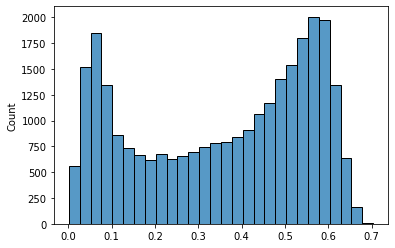

In [53]:
sns.histplot(distances[:,0])

In [22]:
submission = pd.read_csv('/root/data/sample_submission.csv')
submission

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
...,...,...
27951,fff6ff1989b5cd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27952,fff8fd932b42cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27953,fff96371332c16.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27954,fffc1c4d3eabc7.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


In [24]:
submission.predictions[0]

'37c7aba965a5 114207cab555 a6e325d8e924 19fbb960f07d new_individual'

### 2번 : 트레인데이터에 대한 test추론 후 distance (id) 평균값으로 앙상블

In [239]:
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')

In [240]:
neigh.fit(embed_train[full_train_indices])

NearestNeighbors(metric='cosine', n_neighbors=1)

In [241]:
# distance1, indices1 = neigh.kneighbors(embed_train[valid_single_indices], n_neighbors=20, return_distance=True) # 80 %에 해당하는 index
# distance2, indices2 = neigh.kneighbors(embed_train[valid_others_indices], n_neighbors=20, return_distance=True)

In [242]:
indices1 # train중에 가까운 번호

array([[22910, 35936, 35343, ...,  7102, 36331,  4311],
       [ 1033,   483, 15866, ..., 31474, 20167, 11463],
       [15994, 37428, 36043, ...,  3520, 27460,  2768],
       ...,
       [ 9713, 23743,  3332, ..., 33325, 40153,  1349],
       [37664, 11587, 37451, ..., 40783,  8762, 36477],
       [25353, 33380, 10885, ..., 11888, 10482, 20591]])

In [244]:
df

,image,species,individual_id
0,00021adfb725ed.jpg,0,0
1,000562241d384d.jpg,1,1
2,0007c33415ce37.jpg,2,2
3,0007d9bca26a99.jpg,3,3
4,00087baf5cef7a.jpg,1,4
...,...,...,...
51028,fff639a7a78b3f.jpg,4,96
51029,fff8b32daff17e.jpg,17,1482
51030,fff94675cc1aef.jpg,7,8220
51031,fffbc5dd642d8c.jpg,4,13202


In [249]:
full_train_indices, len(full_train_indices)

(array([    0,     3,     4, ..., 51030, 51031, 51032]), 40826)

In [259]:

for n, (g_i, g_d) in enumerate(zip(indices1, distance1)):
    # print(g_i)
    if n == 3:
        for idx, dis in zip(g_i, g_d):
            df_tr = df.iloc[full_train_indices]
            spe, ind = df_tr.iloc[idx].species, df_tr.iloc[idx].individual_id
            print(spe, ind)
    # break

4 2327
4 2327
4 2327
4 2327
4 2327
4 2327
7 8913
7 11962
7 4993
7 9941
7 4993
7 15524
1 15228
7 12323
7 4993
10 439
4 7347
10 439
10 439
7 4558
